In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [41]:
import requests
import pandas as pd
from datetime import datetime, timedelta, date

base_url = 'https://api.energy-charts.info/'
country_code = 'ch'

def process_timestamps(unix_seconds):
    return [datetime.utcfromtimestamp(ts) for ts in unix_seconds]

def get_public_power():
    start_date = date(2010, 1, 1)
    end_date = date(2024, 4, 23)

    start_datetime = start_date.strftime('%Y-%m-%dT%H:%M:%S%z')
    end_datetime = end_date.strftime('%Y-%m-%dT%H:%M:%S%z')
    
    url = base_url + 'public_power'
    params = {
        'country': country_code,
        'start': start_datetime,
        'end': end_datetime
    }

    response = requests.get(url, params=params)
    if response.status_code != 200:
        print(f"Failed to retrieve data: {response.status_code} - {response.text}")
        return pd.DataFrame()

    data = response.json()
    timestamps = process_timestamps(data['unix_seconds'])
    production_data = data['production_types']

    df_list = []
    for entry in production_data:
        if entry['name'] == 'Hydro Run-of-River':
            df = pd.DataFrame({
                'Time': timestamps,
                'Production Type': entry['name'],
                'Power (MW)': entry['data']
            })
            df_list.append(df)

    if not df_list:
        return pd.DataFrame()

    return pd.concat(df_list, ignore_index=True)

# Load data
df = get_public_power()

df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)
    

data = df['Power (MW)'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

print(df.head(25))


                        Production Type  Power (MW)
Time                                               
2015-01-01 00:00:00  Hydro Run-of-River         NaN
2015-01-01 01:00:00  Hydro Run-of-River         NaN
2015-01-01 02:00:00  Hydro Run-of-River         NaN
2015-01-01 03:00:00  Hydro Run-of-River         NaN
2015-01-01 04:00:00  Hydro Run-of-River         NaN
2015-01-01 05:00:00  Hydro Run-of-River         NaN
2015-01-01 06:00:00  Hydro Run-of-River         NaN
2015-01-01 07:00:00  Hydro Run-of-River         NaN
2015-01-01 08:00:00  Hydro Run-of-River         NaN
2015-01-01 09:00:00  Hydro Run-of-River         NaN
2015-01-01 10:00:00  Hydro Run-of-River         NaN
2015-01-01 11:00:00  Hydro Run-of-River         NaN
2015-01-01 12:00:00  Hydro Run-of-River         NaN
2015-01-01 13:00:00  Hydro Run-of-River         NaN
2015-01-01 14:00:00  Hydro Run-of-River         NaN
2015-01-01 15:00:00  Hydro Run-of-River         NaN
2015-01-01 16:00:00  Hydro Run-of-River         NaN
2015-01-01 1

In [42]:
df = df.dropna(how='any')
print(df.head(25))


                        Production Type  Power (MW)
Time                                               
2015-10-12 22:00:00  Hydro Run-of-River     10938.7
2015-10-12 23:00:00  Hydro Run-of-River     10920.8
2015-10-13 00:00:00  Hydro Run-of-River     10974.6
2015-10-13 01:00:00  Hydro Run-of-River     10920.8
2015-10-13 02:00:00  Hydro Run-of-River     11082.2
2015-10-13 03:00:00  Hydro Run-of-River     10992.5
2015-10-13 04:00:00  Hydro Run-of-River     10920.8
2015-10-13 05:00:00  Hydro Run-of-River     11010.4
2015-10-13 06:00:00  Hydro Run-of-River     11028.4
2015-10-13 07:00:00  Hydro Run-of-River     11028.4
2015-10-13 08:00:00  Hydro Run-of-River     11082.2
2015-10-13 09:00:00  Hydro Run-of-River     11064.2
2015-10-13 10:00:00  Hydro Run-of-River     11118.0
2015-10-13 11:00:00  Hydro Run-of-River     11064.2
2015-10-13 12:00:00  Hydro Run-of-River     11225.6
2015-10-13 13:00:00  Hydro Run-of-River     11297.4
2015-10-13 14:00:00  Hydro Run-of-River     11046.3
2015-10-13 1

In [43]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_dataset(data,
 look_back=1):
    """
    Convert an array of values into a dataset matrix suitable for LSTM training.
    
    Parameters:
        data (array): The dataset array containing sequential data.
        look_back (int): Number of previous time steps to use as input variables to predict the next time period.
        
    Returns:
        X (array): Feature dataset.
        y (array): Labels.
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]  # Fetch the input data from the current index to the look_back length
        X.append(a)
        y.append(data[i + look_back, 0])  # The label will be the next data point
    return np.array(X), np.array(y)

# Assume 'data' is loaded and scaled as the 'Power (MW)' from your solar data.
# For example purposes, let's define 'data' here manually:
data = np.array([[i] for i in range(100)])  # Example data generation
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Define the look_back period
look_back = 24  # This means the input for each sample will be sequences of 3 past observations

# Create the dataset
X, y = create_dataset(data, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print("Sample of feature (X) and label (y):")
print("X[0]:", X[0])
print("y[0]:", y[0])

Sample of feature (X) and label (y):
X[0]: [[0.        ]
 [0.01010101]
 [0.02020202]
 [0.03030303]
 [0.04040404]
 [0.05050505]
 [0.06060606]
 [0.07070707]
 [0.08080808]
 [0.09090909]
 [0.1010101 ]
 [0.11111111]
 [0.12121212]
 [0.13131313]
 [0.14141414]
 [0.15151515]
 [0.16161616]
 [0.17171717]
 [0.18181818]
 [0.19191919]
 [0.2020202 ]
 [0.21212121]
 [0.22222222]
 [0.23232323]]
y[0]: 0.24242424242424243


In [63]:
model = Sequential([
     LSTM(60, input_shape=(look_back, 1)),
     Dense(1)
])

optimizer = Adam(learning_rate=0.01) 
model.compile(optimizer=optimizer, loss='mean_squared_error')
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#callbacks=[early_stopping]
history = model.fit(X, y, epochs=200, batch_size=16, validation_split=0.2, verbose=1)

model.summary()


Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.2284 - val_loss: 0.1494
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0711 - val_loss: 0.2558
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0635 - val_loss: 0.0216
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0152 - val_loss: 0.0122
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0076 - val_loss: 0.0704
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0129 - val_loss: 0.0487
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062 - val_loss: 0.0156
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058 - val_loss: 0.0080
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056 - val_loss: 0.0209
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - val_loss: 0.0288
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - val_loss: 0.0153
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021 - val_lo

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 60)             │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,825 (175.10 KB)

 Trainable params: 14,941 (58.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,884 (116.74 KB)

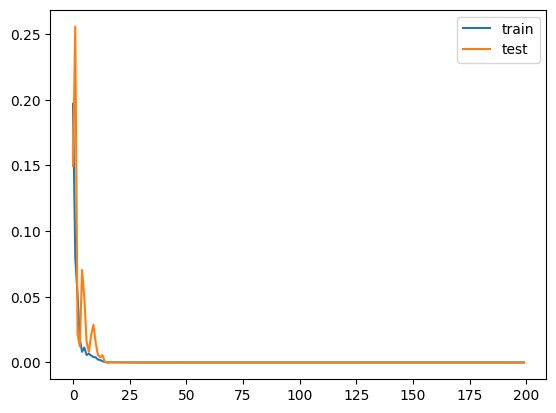

In [64]:

# Plot training loss and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [65]:
predictions = model.predict(X)

predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform([y])

rmse = np.sqrt(mean_squared_error(actuals[0], predictions[:,0]))
mape = np.mean(np.abs((actuals[0] - predictions[:,0]) / actuals[0])) * 100
r_squared = 1 - (np.sum((actuals[0] - predictions[:,0])**2) / np.sum((actuals[0] - np.mean(actuals[0]))**2))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R^2: {r_squared}')

model.save('hydro_run_of_river_lstm.keras')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
RMSE: 0.12733711027692307
MAPE: 0.0929646470957712
R^2: 0.9999663070344859


In [66]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('solar_power_lstm.keras')  # Update the path to where your model is saved

# Scale and prepare the last 24 hours of data
recent_data_scaled = scaler.transform(df['Power (MW)'].tail(24).values.reshape(-1, 1))
recent_data_scaled = recent_data_scaled.reshape(1, 24, 1)

predictions = []
current_batch = recent_data_scaled

# Predict iteratively
for i in range(24):  # Predict the next 24 hours
    current_pred = model.predict(current_batch)[0]  # Predict the next hour
    predictions.append(current_pred)  # Store the prediction
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)  # Update the batch to include the new prediction

# Inverse scale predictions
predicted_original = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Print or store the predictions
predicted_times = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H')
predicted_df = pd.DataFrame(data=predicted_original.flatten(), index=predicted_times, columns=['Predicted Power (MW)'])
print(predicted_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
                     Predicted Power (MW)
2024-04-23 01:00:00            217.417465
202

/var/folders/4n/cyw2bn_96cv6fhpjgbhbl1wc0000gn/T/ipykernel_47752/215734023.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  predicted_times = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H')
